In [2]:
!pip install Keras-Preprocessing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.3 MB/s eta 0:00:00


In [3]:
import warnings
warnings.filterwarnings('ignore')

import time
import spacy
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Embedding, GlobalAveragePooling1D, Dense
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from collections import Counter

In [4]:
def get_kaggle_dataset(dataset_name, extract_to_folder=False, is_competition=False):
    from google.colab import files
    import os
    #if you've already uploaded kaggle.json before, don't do it again
    if not(os.path.exists("kaggle.json")):
      files.upload() #upload kaggle.json
    !pip install --upgrade --force-reinstall --no-deps kaggle
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle
    !chmod 600 /root/.kaggle/kaggle.json

    if is_competition:
        !kaggle competitions download -c {dataset_name}
        if extract_to_folder:
            !mkdir {dataset_name}
            !unzip -q {dataset_name}.zip -d {dataset_name}
        else:
            !unzip -q {dataset_name}.zip
        !rm -f {dataset_name}.zip
    else:
        dataset_url=dataset_name
        dataset_name=dataset_url.split("/")[1]
        !kaggle datasets download -d  {dataset_url}
        if extract_to_folder:
            !mkdir {dataset_name}
            !unzip -q {dataset_name}.zip -d {dataset_name}
        else:
            !unzip -q {dataset_name}.zip
        !rm -f {dataset_name}.zip
    !ls

# Example
get_kaggle_dataset("uciml/sms-spam-collection-dataset")

Saving kaggle.json to kaggle.json
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.16-py3-none-any.whl size=110683 sha256=d1fcdf7170be3f2f6fa8d645b2d7efa1f20f550490ce8e7c877b7f70004cde29
  Stored in directory: /root/.cache/pip/wheels/43/4b/fb/736478af5e8004810081a06259f9aa2f7c3329fc5d03c2c412
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.16
    Uninstalling kaggle-1.5.16:
      Successfully uninstalled kaggle-1.5.16
kaggle.json
100% 211k/211k [00:00<00:00, 394kB/s]
100% 211k/211k [00:00<00:00, 394kB/s]
kaggle.json  sample_data  spam.csv


In [20]:
# Load and preprocess data
sms_data = pd.read_csv('spam.csv', encoding='latin1', usecols=[0, 1])
sms_data.columns = ["label", "message"]


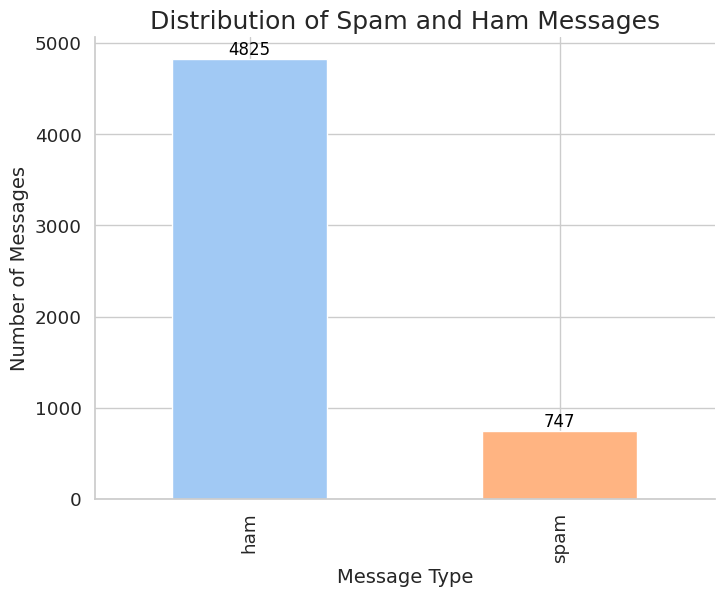

In [23]:
import seaborn as sns

# Set a seaborn style
sns.set(style="whitegrid", font_scale=1.2)

# Plot label distribution
plt.figure(figsize=(8, 6))
colors = sns.color_palette("pastel", 2)  # Choose pastel colors

label_counts = sms_data["label"].value_counts()
label_counts.plot(kind="bar", color=colors)

# Title and labels
plt.title("Distribution of Spam and Ham Messages", fontsize=18)
plt.ylabel("Number of Messages", fontsize=14)
plt.xlabel("Message Type", fontsize=14)

# Add data labels on top of each bar
for i, count in enumerate(label_counts):
    plt.text(i, count + 5, str(count), ha='center', va='bottom', fontsize=12, color='black')

# Remove top and right spines for aesthetics
sns.despine(top=True, right=True)

# Show the plot
plt.show()


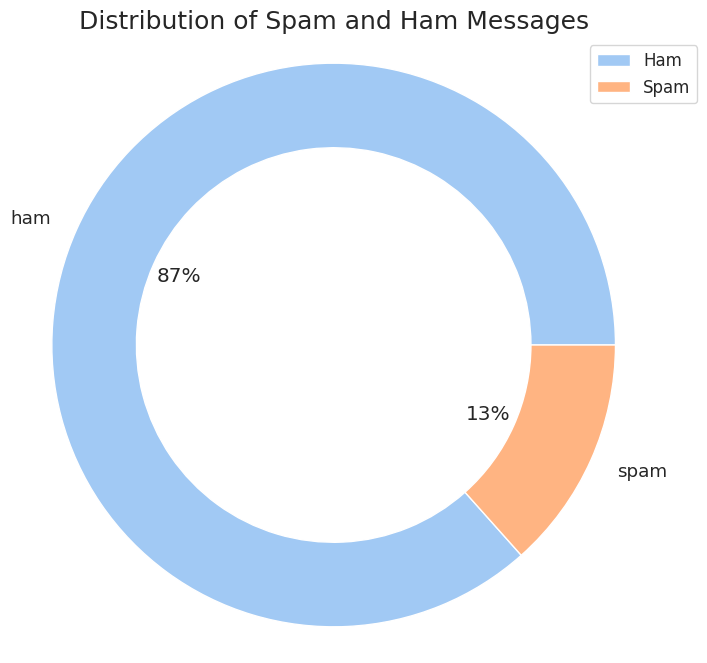

In [24]:
# Set a seaborn style
sns.set(style="whitegrid", font_scale=1.2)

# Plot pie chart
plt.figure(figsize=(8, 8))
colors = sns.color_palette("pastel", 2)  # Choose pastel colors

label_counts = sms_data["label"].value_counts()
label_counts.plot(kind="pie", autopct='%.0f%%', colors=colors, wedgeprops=dict(width=0.3))

# Title and labels
plt.title("Distribution of Spam and Ham Messages", fontsize=18)
plt.ylabel("")  # Remove the default label

# Equal aspect ratio ensures that the pie is drawn as a circle
plt.axis('equal')

# Add a legend
plt.legend(["Ham", "Spam"], loc="upper right", bbox_to_anchor=(1.1, 1), fontsize=12)

# Show the plot
plt.show()


In [8]:
# Display dataset statistics
sms_data.groupby("label").describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

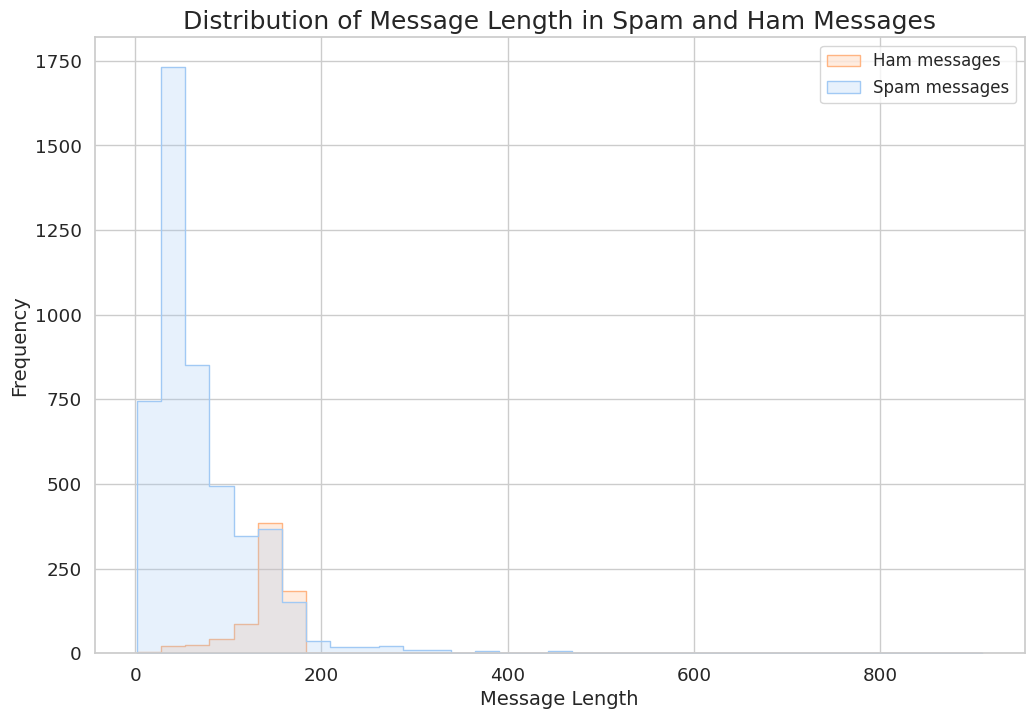

In [27]:
# Set a seaborn style
sns.set(style="whitegrid", font_scale=1.2)

# Analyze message length
sms_data["length"] = sms_data["message"].apply(len)

# Plot histogram
plt.figure(figsize=(12, 8))
colors = sns.color_palette("pastel", 2)  # Choose pastel colors

sns.histplot(data=sms_data, x="length", hue="label", bins=35, element="step", common_norm=False, palette=colors)

# Title and labels
plt.title("Distribution of Message Length in Spam and Ham Messages", fontsize=18)
plt.xlabel("Message Length", fontsize=14)
plt.ylabel("Frequency", fontsize=14)

# Add a legend
plt.legend(["Ham messages", "Spam messages"], loc="upper right", fontsize=12)

# Show the plot
plt.show()


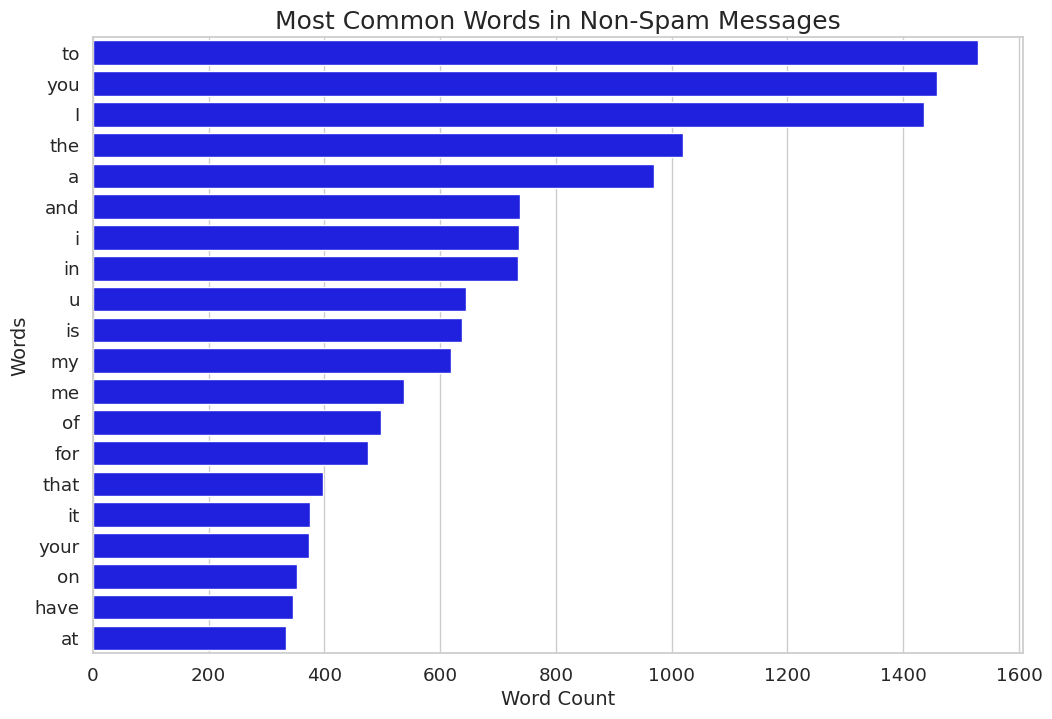

In [28]:
# Set a seaborn style
sns.set(style="whitegrid", font_scale=1.2)

# Plot common words in non-spam messages
common_ham = Counter(" ".join(sms_data[sms_data["label"] == "ham"]["message"]).split()).most_common(20)
df_common_ham = pd.DataFrame(common_ham, columns=["Word", "Count"])

# Plot bar chart
plt.figure(figsize=(12, 8))
sns.barplot(x="Count", y="Word", data=df_common_ham, color="blue")

# Title and labels
plt.title("Most Common Words in Non-Spam Messages", fontsize=18)
plt.xlabel("Word Count", fontsize=14)
plt.ylabel("Words", fontsize=14)

# Show the plot
plt.show()


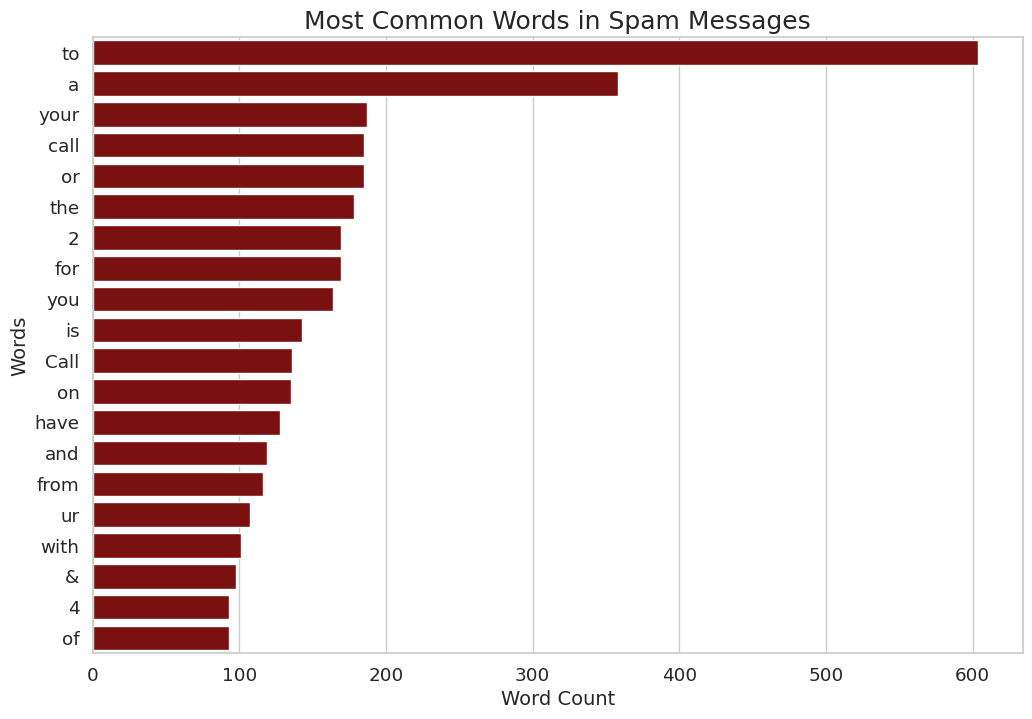

In [30]:
# Set a seaborn style
sns.set(style="whitegrid", font_scale=1.2)

# Plot common words in spam messages
common_spam = Counter(" ".join(sms_data[sms_data["label"] == "spam"]["message"]).split()).most_common(20)
df_common_spam = pd.DataFrame(common_spam, columns=["Word", "Count"])

# Plot bar chart
plt.figure(figsize=(12, 8))
sns.barplot(x="Count", y="Word", data=df_common_spam, color="darkred")

# Title and labels
plt.title("Most Common Words in Spam Messages", fontsize=18)
plt.xlabel("Word Count", fontsize=14)
plt.ylabel("Words", fontsize=14)

# Show the plot
plt.show()


In [12]:
# Model parameters
vocab_size = 400
oov_token = "<OOV>"
max_length = 250
embedding_dim = 16
num_epochs = 50

In [13]:
# Preprocess data for model training
label_encoding = {"ham": 0, "spam": 1}
sms_data["label"] = sms_data["label"].replace(label_encoding)

X = sms_data["message"]
y = sms_data["label"]

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(X)
X = pad_sequences(tokenizer.texts_to_sequences(X), maxlen=max_length)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=7)

In [14]:
# Build and train the model
model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    GlobalAveragePooling1D(),
    Dense(24, activation="relu"),
    Dense(1, activation="sigmoid")
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 16)           6400      
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 6833 (26.69 KB)
Trainable params: 6833 (26.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [47]:
# Plot the model architecture
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

history = model.fit(X_train, y_train, epochs=num_epochs, validation_data=(X_test, y_test), verbose=2)


Epoch 1/50
131/131 - 1s - loss: 0.0290 - accuracy: 0.9911 - val_loss: 0.0631 - val_accuracy: 0.9849 - 715ms/epoch - 5ms/step
Epoch 2/50
131/131 - 1s - loss: 0.0266 - accuracy: 0.9919 - val_loss: 0.0551 - val_accuracy: 0.9828 - 520ms/epoch - 4ms/step
Epoch 3/50
131/131 - 1s - loss: 0.0274 - accuracy: 0.9899 - val_loss: 0.0598 - val_accuracy: 0.9842 - 957ms/epoch - 7ms/step
Epoch 4/50
131/131 - 1s - loss: 0.0259 - accuracy: 0.9919 - val_loss: 0.0687 - val_accuracy: 0.9856 - 1s/epoch - 8ms/step
Epoch 5/50
131/131 - 1s - loss: 0.0257 - accuracy: 0.9911 - val_loss: 0.0593 - val_accuracy: 0.9856 - 994ms/epoch - 8ms/step
Epoch 6/50
131/131 - 1s - loss: 0.0255 - accuracy: 0.9921 - val_loss: 0.0654 - val_accuracy: 0.9849 - 731ms/epoch - 6ms/step
Epoch 7/50
131/131 - 1s - loss: 0.0248 - accuracy: 0.9919 - val_loss: 0.0583 - val_accuracy: 0.9849 - 1s/epoch - 8ms/step
Epoch 8/50
131/131 - 1s - loss: 0.0250 - accuracy: 0.9921 - val_loss: 0.0598 - val_accuracy: 0.9849 - 969ms/epoch - 7ms/step
Epoch 

In [16]:
# Evaluate and save the model
result = model.evaluate(X_test, y_test)
accuracy = result[1]
print(f"Accuracy: {accuracy * 100:.2f}%")

model.save("spam_classifier_model")


44/44 [==============================] - 0s 2ms/step - loss: 0.0551 - accuracy: 0.9842
Accuracy: 98.42%


In [17]:
# Load the model for predictions
loaded_model = tf.keras.models.load_model("spam_classifier_model")

In [41]:
def get_predictions(texts):
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=max_length)
    predictions = loaded_model.predict(padded_sequences)

    for i, pred in enumerate(predictions):
        print()
        if pred > 0.5:
            print(f"    [SPAM] << {texts[i]}")
        else:
            print(f"[NOT SPAM] << {texts[i]}")


In [46]:
# Sample text predictions
sample_texts = [
    "Unlock amazing deals on our latest products! Limited stock available.",
    "Reminder: Your appointment is scheduled for tomorrow at 2 PM. Don't miss it!",
    "Congratulations! You've been selected for a special discount. Claim it now.",
    "Good morning! Wishing you a wonderful day ahead.",
    "Alert: Your account security has been compromised. Click the link to secure your account.",
    "Reply to this message with 'YES' to receive our weekly newsletter."
]

get_predictions(sample_texts)


1/1 [==============================] - 0s 25ms/step

[NOT SPAM] << Unlock amazing deals on our latest products! Limited stock available.

[NOT SPAM] << Reminder: Your appointment is scheduled for tomorrow at 2 PM. Don't miss it!

    [SPAM] << Congratulations! You've been selected for a special discount. Claim it now.

[NOT SPAM] << Good morning! Wishing you a wonderful day ahead.

    [SPAM] << Alert: Your account security has been compromised. Click the link to secure your account.

    [SPAM] << Reply to this message with 'YES' to receive our weekly newsletter.


In [44]:
# get custom user input for prediction
user_input = input("Enter message to check: ")

get_predictions([user_input])

Enter message to check: Get $23,423 for free today by simply clicking install. Install and win thousands for free
1/1 [==============================] - 0s 17ms/step

    [SPAM] << Get $23,423 for free today by simply clicking install. Install and win thousands for free
